In [1]:
# 1. Clone and setup FBPINNs
!git clone https://github.com/thiae/FBPINNs.git
%cd FBPINNs
!python colab_setup.py

# 2. Navigate to poroelasticity and setup paths
%cd poroelasticity
!python setup_path.py

# 3. Validate everything works
!python simple_validation.py

Cloning into 'FBPINNs'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 575 (delta 145), reused 113 (delta 75), pack-reused 346 (from 2)
Receiving objects: 100% (575/575), 14.72 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (290/290), done.
/content/FBPINNs
FBPINNs Colab Setup
Setup method: auto

Installing dependencies...
  Detected Google Colab - using GPU JAX
  Installing jax[cuda12]>=0.4.8...
  SUCCESS: jax[cuda12]>=0.4.8 installed successfully
  Installing optax>=0.1.4...
  SUCCESS: optax>=0.1.4 installed successfully
  Installing numpy>=1.24.2...
  SUCCESS: numpy>=1.24.2 installed successfully
  Installing scipy>=1.10.1...
  SUCCESS: scipy>=1.10.1 installed successfully
  Installing matplotlib>=3.7.1...
  SUCCESS: matplotlib>=3.7.1 installed successfully
  Installing tensorboardX>=2.6...
  SUCCESS: tensorboardX>=2.6 installed successfully
  Installing ipython>=8.12.0...
  

In [2]:
# ENVIRONMENT SETUP AND IMPROVED CLASS IMPLEMENTATION
print("="*80)

import os
import sys
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import optax

print("🔧 Setting up FBPINNs path...")

# Get the FBPINNs root directory (parent of current directory)
current_dir = Path.cwd()
fbpinns_root = current_dir.parent

print(f"Current directory: {current_dir}")
print(f"FBPINNs root: {fbpinns_root}")

# Add FBPINNs root to Python path (for fbpinns imports)
if str(fbpinns_root) not in sys.path:
    sys.path.insert(0, str(fbpinns_root))
    print(f" Added {fbpinns_root} to Python path")

# Add current directory to Python path (for local imports)
if str(current_dir) not in sys.path:
    sys.path.insert(0, str(current_dir))
    print(f" Added {current_dir} to Python path")

# Test fbpinns import first
try:
    import fbpinns
    print(" fbpinns module successfully imported")
except ImportError as e:
    print(f" fbpinns import failed: {e}")
    raise

# Import FBPINNs components
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer

print(" All imports successful!")

🔧 Setting up FBPINNs path...
Current directory: /content/FBPINNs/poroelasticity
FBPINNs root: /content/FBPINNs
 Added /content/FBPINNs to Python path
 Added /content/FBPINNs/poroelasticity to Python path
 fbpinns module successfully imported
 All imports successful!


In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import optax
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer

class BiotCoupled2D(Problem):
    """
    Unified 2D Biot Poroelasticity Problem with Hard BC Implementation

    : Uses constraining_fn  for hard BC enforcement
    """

    @staticmethod
    def init_params(E=5000.0, nu=0.25, alpha=0.8, k=1.0, mu=1.0):
        """Initialize material parameters for both mechanics and flow"""

        E = jnp.array(E, dtype=jnp.float32)
        nu = jnp.array(nu, dtype=jnp.float32)
        alpha = jnp.array(alpha, dtype=jnp.float32)
        k = jnp.array(k, dtype=jnp.float32)
        mu = jnp.array(mu, dtype=jnp.float32)

        # Calculate the derived parameters
        G = E / (2.0 * (1.0 + nu))
        lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

        static_params = {
            "dims": (3, 2),  # 3 outputs (u_x, u_y, p), 2 inputs (x, y)
            # Mechanics parameters
            "E": E,
            "nu": nu,
            "G": G,
            "lam": lam,
            # Flow parameters
            "k": k,
            "mu": mu,
            # Coupling parameter
            "alpha": alpha
        }
        trainable_params = {}
        return static_params, trainable_params

    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        """

        This method is called by FBPINNs after network evaluation.
        Transform network output to satisfy boundary conditions exactly.

        Args:
            all_params: Parameter dictionary
            x_batch: Input coordinates [N, 2]
            u: Raw network output [N, 3] for [ux, uy, p]

        Returns:
            Transformed output with hard BCs enforced [N, 3]
        """
        x = x_batch[:, 0:1]  # x coordinates
        y = x_batch[:, 1:2]  # y coordinates

        # Raw outputs from network
        ux_raw = u[:, 0:1]
        uy_raw = u[:, 1:2]
        p_raw = u[:, 2:3]

        # HARD BC ENFORCEMENT - Mathematical transformations

        # Pressure: p(0,y)=1, p(1,y)=0
        # Linear interpolation from 1 to 0, plus interior variation
        p = (1.0 - x) + p_raw * x * (1.0 - x) * 4.0

        # X-displacement: ux(0,y)=0
        # Multiply by x to force zero at x=0
        ux = ux_raw * x

        # Y-displacement: uy(x,0)=0 and uy(0,y)=0
        # Multiply by x*y to force zero at both x=0 and y=0
        uy = uy_raw * x * y

        # Return transformed output with enforced BCs
        return jnp.concatenate([ux, uy, p], axis=-1)

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        """Sample constraints for both mechanics and flow equations"""

        dom = all_params["static"].setdefault("domain", {})
        d = all_params["static"]["problem"]["dims"][1]
        dom.setdefault("xmin", jnp.zeros((d,), dtype=jnp.float32))
        dom.setdefault("xmax", jnp.ones((d,),  dtype=jnp.float32))
        dom.setdefault("xd", d)

        bs0 = batch_shapes[0]
        if sampler == "grid" and len(bs0) == 1 and d > 1:
            batch_shape_phys = (bs0[0],) * d
        else:
            batch_shape_phys = bs0

        # Sample interior points for physics
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shape_phys)

        # Required derivatives for physics equations
        required_ujs_phys = (
            # u_x derivatives
            (0, (0,)),
            (0, (0,0)),
            (0, (1,1)),
            (0, (0,1)),
            # u_y derivatives
            (1, (1,)),
            (1, (0,0)),
            (1, (1,1)),
            (1, (0,1)),
            # p derivatives
            (2, (0,)),
            (2, (1,)),
            (2, (0,0)),
            (2, (1,1))
        )

        # Boundary sampling (minimal since BCs are hard enforced)
        boundary_batch_shapes = batch_shapes[1:5]
        x_batches_boundaries = domain.sample_boundaries(all_params, key, sampler, boundary_batch_shapes)

        x_batch_left = x_batches_boundaries[0]
        x_batch_right = x_batches_boundaries[1]
        x_batch_bottom = x_batches_boundaries[2]
        x_batch_top = x_batches_boundaries[3]

        # Minimal boundary constraints (just evaluate the fields)
        required_ujs_boundary = ((0, ()), (1, ()), (2, ()))

        return [
            # Physics constraints
            [x_batch_phys, required_ujs_phys],
            # Boundary constraints (minimal since hard enforced)
            [x_batch_left, required_ujs_boundary],
            [x_batch_right, required_ujs_boundary],
            [x_batch_bottom, required_ujs_boundary],
            [x_batch_top, required_ujs_boundary]
        ]

    @staticmethod
    def loss_fn(all_params, constraints):
        """
        Loss function focusing on physics (BCs are hard enforced)
        """
        # Get material parameters
        G = all_params["static"]["problem"]["G"]
        lam = all_params["static"]["problem"]["lam"]
        alpha = all_params["static"]["problem"]["alpha"]
        k = all_params["static"]["problem"]["k"]

        # Physics constraints
        x_batch_phys = constraints[0][0]
        # Unpack derivatives (these are computed after constraining_fn is applied)
        duxdx, d2uxdx2, d2uxdy2, d2uxdxdy, duydy, d2uydx2, d2uydy2, d2uydxdy, dpdx, dpdy, d2pdx2, d2pdy2 = constraints[0][1:13]

        # Compute divergence of displacement
        div_u = duxdx + duydy

        # Mechanics equations
        equilibrium_x = ((2*G + lam)*d2uxdx2 + lam*d2uydxdy +
                        G*d2uxdy2 + G*d2uydxdy + alpha*dpdx)

        equilibrium_y = (G*d2uxdxdy + G*d2uydx2 +
                        lam*d2uxdxdy + (2*G + lam)*d2uydy2 + alpha*dpdy)

        mechanics_loss = jnp.mean(equilibrium_x**2) + jnp.mean(equilibrium_y**2)

        # Flow equation
        laplacian_p = d2pdx2 + d2pdy2
        flow_residual = -k * laplacian_p + alpha * div_u
        flow_loss = jnp.mean(flow_residual**2)

        # No BC penalties needed - they're hard enforced
        total_loss = mechanics_loss + flow_loss

        return total_loss

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """No exact solution - returns None for physics only training"""
        return None


class BiotCoupledTrainer:
    """
    Trainer with hard BC enforcement via constraining_fn
    """

    def __init__(self):
        """Initialize with optimal settings"""

        self.config = Constants(
            run="biot_coupled_2d",
            domain=RectangularDomainND,
            domain_init_kwargs={'xmin': jnp.array([0., 0.]), 'xmax': jnp.array([1., 1.])},
            problem=BiotCoupled2D,
            problem_init_kwargs={'E': 5000.0, 'nu': 0.25, 'alpha': 0.8, 'k': 1.0, 'mu': 1.0},
            decomposition=RectangularDecompositionND,
            decomposition_init_kwargs={
                'subdomain_xs': [jnp.linspace(0, 1, 3), jnp.linspace(0, 1, 3)],
                'subdomain_ws': [0.8 * jnp.ones(3), 0.8 * jnp.ones(3)],
                'unnorm': (0., 1.)
            },
            network=FCN,
            network_init_kwargs={'layer_sizes': [2, 64, 64, 64, 3], 'activation': 'tanh'},
            ns=((100, 100), (50,), (50,), (50,), (50,)),
            n_test=(20, 20),
            n_steps=5000,  # Increased for better convergence
            optimiser_kwargs={'learning_rate': 1e-3},
            summary_freq=100,
            test_freq=250,
            show_figures=False,
            save_figures=False,
            clear_output=True
        )
        self.trainer = FBPINNTrainer(self.config)
        self.all_params = None

    def train(self, n_steps=None):
        """Train with hard BC enforcement via constraining_fn"""
        if n_steps is not None:
            self.config.n_steps = n_steps
            self.trainer.c.n_steps = n_steps

        print("="*60)
        print("Training with Hard BC ")
        print("Using constraining_fn method")
        print("Boundary conditions are mathematically guaranteed")
        print("="*60)

        self.all_params = self.trainer.train()
        return self.all_params

    def predict(self, x_points):
        """Predict using FBPINN_solution (which applies constraining_fn)"""
        if self.all_params is None:
            raise ValueError("Model not trained yet")

        if not isinstance(x_points, jnp.ndarray):
            x_points = jnp.array(x_points)

        from fbpinns.analysis import FBPINN_solution

        # All subdomains active for prediction
        active = jnp.ones(self.all_params["static"]["decomposition"]["m"], dtype=jnp.int32)

        # This will apply constraining_fn internally
        predictions = FBPINN_solution(self.config, self.all_params, active, x_points)

        return predictions

    def verify_bcs(self, n_points=100):
        """Verify that boundary conditions are satisfied"""
        print("\n" + "="*60)
        print("Boundary Condition Verification")
        print("="*60)

        # Check left boundary (x=0)
        y_test = jnp.linspace(0, 1, n_points)
        left_points = jnp.column_stack([jnp.zeros(n_points), y_test])
        left_pred = self.predict(left_points)

        # Check right boundary (x=1)
        right_points = jnp.column_stack([jnp.ones(n_points), y_test])
        right_pred = self.predict(right_points)

        # Check bottom boundary (y=0)
        x_test = jnp.linspace(0, 1, n_points)
        bottom_points = jnp.column_stack([x_test, jnp.zeros(n_points)])
        bottom_pred = self.predict(bottom_points)

        print(f"Left boundary (x=0):")
        print(f"  ux = 0: max violation = {jnp.max(jnp.abs(left_pred[:, 0])):.6e}")
        print(f"  uy = 0: max violation = {jnp.max(jnp.abs(left_pred[:, 1])):.6e}")
        print(f"  p = 1:  max violation = {jnp.max(jnp.abs(left_pred[:, 2] - 1.0)):.6e}")

        print(f"\nRight boundary (x=1):")
        print(f"  p = 0:  max violation = {jnp.max(jnp.abs(right_pred[:, 2])):.6e}")

        print(f"\nBottom boundary (y=0):")
        print(f"  uy = 0: max violation = {jnp.max(jnp.abs(bottom_pred[:, 1])):.6e}")

        # Check if all violations are small
        all_violations = [
            jnp.max(jnp.abs(left_pred[:, 0])),
            jnp.max(jnp.abs(left_pred[:, 1])),
            jnp.max(jnp.abs(left_pred[:, 2] - 1.0)),
            jnp.max(jnp.abs(right_pred[:, 2])),
            jnp.max(jnp.abs(bottom_pred[:, 1]))
        ]

        max_violation = max(all_violations)
        if max_violation < 1e-6:
            print("\nStatus: PERFECT - All BCs satisfied to machine precision")
        elif max_violation < 1e-3:
            print("\nStatus: EXCELLENT - All BCs satisfied within tolerance")
        elif max_violation < 1e-2:
            print("\nStatus: GOOD - Minor BC violations")
        else:
            print(f"\nStatus: CHECK - Max violation: {max_violation:.3e}")

        print("="*60)
        return max_violation < 1e-2

    def compute_physics_metrics(self, n_points=50, method='autodiff'):
        """
        Unified physics validation metrics with option for different derivative methods.

        Args:
            n_points: Number of points along each dimension for evaluation grid
            method: Method for computing derivatives: 'autodiff' (more accurate) or
                   'finite_diff' (faster, better for larger grids)

        Returns:
            Dictionary containing all computed metrics including relative errors
        """
        if self.all_params is None:
            raise ValueError("Model not trained yet")

        print("\n" + "="*60)
        print(f"PHYSICS VALIDATION METRICS (using {method})")
        print("="*60)

        # Create evaluation grid
        if method == 'finite_diff':
            # Avoid boundaries for finite difference method to reduce edge effects
            x = jnp.linspace(0.1, 0.9, n_points)
            y = jnp.linspace(0.1, 0.9, n_points)
        else:
            # Full domain for autodiff method
            x = jnp.linspace(0, 1, n_points)
            y = jnp.linspace(0, 1, n_points)

        X, Y = jnp.meshgrid(x, y)
        points = jnp.column_stack([X.flatten(), Y.flatten()])

        # Get material parameters
        G = self.all_params["static"]["problem"]["G"]
        lam = self.all_params["static"]["problem"]["lam"]
        alpha = self.all_params["static"]["problem"]["alpha"]
        k = self.all_params["static"]["problem"]["k"]
        E = self.all_params["static"]["problem"]["E"]

        # Predict at all points
        u_pred = self.predict(points)
        ux = u_pred[:, 0]
        uy = u_pred[:, 1]
        p = u_pred[:, 2]

        # Compute characteristic scales for normalization (used for relative errors)
        L = 1.0  # Domain size
        p_scale = 1.0  # Maximum pressure (BC value)
        u_scale = jnp.maximum(jnp.max(jnp.abs(ux)), jnp.max(jnp.abs(uy)))
        if u_scale < 1e-10:
            u_scale = p_scale * L / E  # Theoretical scale

        elastic_force_scale = E * u_scale / L**2
        pressure_gradient_scale = k * p_scale / L**2

        # Calculate derivatives based on selected method
        if method == 'autodiff':
            # Use JAX autodiff (more accurate but potentially slower)
            # Helper function to create derivative functions
            def create_derivative_fn(component, order):
                """Create a function that computes derivatives of a component"""
                if component == 'ux':
                    idx = 0
                elif component == 'uy':
                    idx = 1
                else:  # pressure
                    idx = 2

                def predict_component(xy):
                    return self.predict(xy.reshape(1, -1))[0, idx]

                if order == 'dx':
                    return jax.grad(predict_component, argnums=0)
                elif order == 'dy':
                    return jax.grad(predict_component, argnums=1)
                elif order == 'dx2':
                    return jax.grad(jax.grad(predict_component, argnums=0), argnums=0)
                elif order == 'dy2':
                    return jax.grad(jax.grad(predict_component, argnums=1), argnums=1)
                elif order == 'dxdy':
                    return jax.grad(jax.grad(predict_component, argnums=0), argnums=1)

            # Vectorize the derivative functions
            d_ux_dx_fn = jax.vmap(create_derivative_fn('ux', 'dx'))
            d_ux_dy_fn = jax.vmap(create_derivative_fn('ux', 'dy'))
            d2_ux_dx2_fn = jax.vmap(create_derivative_fn('ux', 'dx2'))
            d2_ux_dy2_fn = jax.vmap(create_derivative_fn('ux', 'dy2'))
            d2_ux_dxdy_fn = jax.vmap(create_derivative_fn('ux', 'dxdy'))

            d_uy_dx_fn = jax.vmap(create_derivative_fn('uy', 'dx'))
            d_uy_dy_fn = jax.vmap(create_derivative_fn('uy', 'dy'))
            d2_uy_dx2_fn = jax.vmap(create_derivative_fn('uy', 'dx2'))
            d2_uy_dy2_fn = jax.vmap(create_derivative_fn('uy', 'dy2'))
            d2_uy_dxdy_fn = jax.vmap(create_derivative_fn('uy', 'dxdy'))

            d_p_dx_fn = jax.vmap(create_derivative_fn('p', 'dx'))
            d_p_dy_fn = jax.vmap(create_derivative_fn('p', 'dy'))
            d2_p_dx2_fn = jax.vmap(create_derivative_fn('p', 'dx2'))
            d2_p_dy2_fn = jax.vmap(create_derivative_fn('p', 'dy2'))

            # Sample points for derivative evaluation (use subset for efficiency)
            sample_indices = jax.random.randint(
                jax.random.PRNGKey(0),
                shape=(min(1000, n_points*n_points),),
                minval=0,
                maxval=n_points*n_points
            )
            sample_points = points[sample_indices]

            # Compute derivatives
            print("Computing derivatives using JAX autodiff...")

            d_ux_dx = d_ux_dx_fn(sample_points)
            d_ux_dy = d_ux_dy_fn(sample_points)
            d2_ux_dx2 = d2_ux_dx2_fn(sample_points)
            d2_ux_dy2 = d2_ux_dy2_fn(sample_points)
            d2_ux_dxdy = d2_ux_dxdy_fn(sample_points)

            d_uy_dx = d_uy_dx_fn(sample_points)
            d_uy_dy = d_uy_dy_fn(sample_points)
            d2_uy_dx2 = d2_uy_dx2_fn(sample_points)
            d2_uy_dy2 = d2_uy_dy2_fn(sample_points)
            d2_uy_dxdy = d2_uy_dxdy_fn(sample_points)

            d_p_dx = d_p_dx_fn(sample_points)
            d_p_dy = d_p_dy_fn(sample_points)
            d2_p_dx2 = d2_p_dx2_fn(sample_points)
            d2_p_dy2 = d2_p_dy2_fn(sample_points)

            # Compute physics residuals
            # Divergence of displacement
            div_u = d_ux_dx + d_uy_dy

            # Mechanics equations
            equilibrium_x = ((2*G + lam)*d2_ux_dx2 + lam*d2_uy_dxdy +
                           G*d2_ux_dy2 + G*d2_uy_dxdy + alpha*d_p_dx)

            equilibrium_y = (G*d2_ux_dxdy + G*d2_uy_dx2 +
                           lam*d2_ux_dxdy + (2*G + lam)*d2_uy_dy2 + alpha*d_p_dy)

            # Flow equation
            laplacian_p = d2_p_dx2 + d2_p_dy2
            flow_residual = -k * laplacian_p + alpha * div_u

        else:  # 'finite_diff'
            # Use finite differences (faster but less accurate)
            print("Computing derivatives using finite differences...")

            dx = x[1] - x[0]
            dy = y[1] - y[0]

            # Reshape for finite differences
            ux_grid = ux.reshape(n_points, n_points)
            uy_grid = uy.reshape(n_points, n_points)
            p_grid = p.reshape(n_points, n_points)

            # First derivatives
            dux_dx = jnp.gradient(ux_grid, dx, axis=1).flatten()
            dux_dy = jnp.gradient(ux_grid, dy, axis=0).flatten()
            duy_dx = jnp.gradient(uy_grid, dx, axis=1).flatten()
            duy_dy = jnp.gradient(uy_grid, dy, axis=0).flatten()
            dp_dx = jnp.gradient(p_grid, dx, axis=1).flatten()
            dp_dy = jnp.gradient(p_grid, dy, axis=0).flatten()

            # Second derivatives
            d2ux_dx2 = jnp.gradient(jnp.gradient(ux_grid, dx, axis=1), dx, axis=1).flatten()
            d2ux_dy2 = jnp.gradient(jnp.gradient(ux_grid, dy, axis=0), dy, axis=0).flatten()
            d2ux_dxdy = jnp.gradient(jnp.gradient(ux_grid, dx, axis=1), dy, axis=0).flatten()

            d2uy_dx2 = jnp.gradient(jnp.gradient(uy_grid, dx, axis=1), dx, axis=1).flatten()
            d2uy_dy2 = jnp.gradient(jnp.gradient(uy_grid, dy, axis=0), dy, axis=0).flatten()
            d2uy_dxdy = jnp.gradient(jnp.gradient(uy_grid, dx, axis=1), dy, axis=0).flatten()

            d2p_dx2 = jnp.gradient(jnp.gradient(p_grid, dx, axis=1), dx, axis=1).flatten()
            d2p_dy2 = jnp.gradient(jnp.gradient(p_grid, dy, axis=0), dy, axis=0).flatten()

            # Compute physics residuals
            div_u = dux_dx + duy_dy

            # Mechanics equations residuals
            equilibrium_x = ((2*G + lam)*d2ux_dx2 + lam*d2uy_dxdy +
                             G*d2ux_dy2 + G*d2uy_dxdy + alpha*dp_dx)

            equilibrium_y = (G*d2ux_dxdy + G*d2uy_dx2 +
                             lam*d2ux_dxdy + (2*G + lam)*d2uy_dy2 + alpha*dp_dy)

            # Flow equation residual
            laplacian_p = d2p_dx2 + d2p_dy2
            flow_residual = -k * laplacian_p + alpha * div_u

        # Compute absolute error metrics
        mechanics_x_rms = jnp.sqrt(jnp.mean(equilibrium_x**2))
        mechanics_y_rms = jnp.sqrt(jnp.mean(equilibrium_y**2))
        mechanics_rms = jnp.sqrt((mechanics_x_rms**2 + mechanics_y_rms**2) / 2)
        flow_rms = jnp.sqrt(jnp.mean(flow_residual**2))

        # Compute L-infinity norms
        mechanics_x_linf = jnp.max(jnp.abs(equilibrium_x))
        mechanics_y_linf = jnp.max(jnp.abs(equilibrium_y))
        mechanics_linf = jnp.maximum(mechanics_x_linf, mechanics_y_linf)
        flow_linf = jnp.max(jnp.abs(flow_residual))

        # Compute L2 norms
        mechanics_x_l2 = jnp.sqrt(jnp.sum(equilibrium_x**2))
        mechanics_y_l2 = jnp.sqrt(jnp.sum(equilibrium_y**2))
        mechanics_l2 = jnp.sqrt(mechanics_x_l2**2 + mechanics_y_l2**2)
        flow_l2 = jnp.sqrt(jnp.sum(flow_residual**2))

        # Compute relative error metrics
        # Normalize mechanics residual by elastic force scale
        mechanics_x_rel = mechanics_x_rms / elastic_force_scale
        mechanics_y_rel = mechanics_y_rms / elastic_force_scale
        mechanics_rel = mechanics_rms / elastic_force_scale

        # Normalize flow residual by pressure gradient scale
        flow_rel = flow_rms / pressure_gradient_scale

        # Determine overall status based on relative errors
        total_rel = (mechanics_rel + flow_rel) / 2
        if total_rel < 1e-3:
            status = "EXCELLENT"
        elif total_rel < 1e-2:
            status = "VERY GOOD"
        elif total_rel < 5e-2:
            status = "GOOD"
        elif total_rel < 1e-1:
            status = "ACCEPTABLE"
        else:
            status = "NEEDS IMPROVEMENT"

        # Print detailed results in a table
        print("\n┌─────────────────┬──────────────┬──────────────┬──────────────┐")
        print("  │ Equation        │ RMS Absolute │ RMS Relative │ L-inf Norm   │")
        print("  ├─────────────────┼──────────────┼──────────────┼──────────────┤")
        print(f" │ Mechanics (x)   │ {mechanics_x_rms:.2e} │ {mechanics_x_rel:.2e} │ {mechanics_x_linf:.2e} │")
        print(f" │ Mechanics (y)   │ {mechanics_y_rms:.2e} │ {mechanics_y_rel:.2e} │ {mechanics_y_linf:.2e} │")
        print(f" │ Mechanics (avg) │ {mechanics_rms:.2e}   │ {mechanics_rel:.2e} │ {mechanics_linf:.2e} │")
        print(f" │ Flow            │ {flow_rms:.2e}        │ {flow_rel:.2e} │ {flow_linf:.2e} │")
        print("  └─────────────────┴──────────────┴──────────────┴──────────────┘")

        # Print scale information
        print(f"\nCharacteristic Scales:")
        print(f"  Domain size (L): {L:.2f}")
        print(f"  Pressure scale: {p_scale:.2f}")
        print(f"  Displacement scale: {u_scale:.2e}")
        print(f"  Elastic force scale: {elastic_force_scale:.2e}")
        print(f"  Pressure gradient scale: {pressure_gradient_scale:.2e}")

        print(f"\nOverall physics satisfaction: {status} (avg relative error: {total_rel:.2e})")

        # Conservation check
        print("\nPhysics Conservation Check:")
        print(f"  Mass conservation (avg residual): {flow_rms:.2e}")
        print(f"  Momentum conservation (avg residual): {mechanics_rms:.2e}")

        # Store residuals for spatial distribution plotting if using finite differences
        # (this enables plotting with plot_residual_spatial_distribution method)
        if method == 'finite_diff':
            self.last_residuals = {
                'x': X,
                'y': Y,
                'mechanics_x': equilibrium_x.reshape(n_points, n_points),
                'mechanics_y': equilibrium_y.reshape(n_points, n_points),
                'flow': flow_residual.reshape(n_points, n_points),
                'div_u': div_u.reshape(n_points, n_points)
            }
        elif hasattr(self, 'last_residuals'):
            # If we're using autodiff but have previously stored residuals, let the user know
            print("\nNote: Residual spatial data is not updated when using autodiff method.")
            print("Previous spatial data will be used if plotting residual distribution.")

        print("="*60)

        # Return comprehensive metrics as dictionary
        return {
            # Absolute metrics
            "mechanics_x_rms": float(mechanics_x_rms),
            "mechanics_y_rms": float(mechanics_y_rms),
            "mechanics_rms": float(mechanics_rms),
            "flow_rms": float(flow_rms),
            "mechanics_x_l2": float(mechanics_x_l2) if method == 'autodiff' else None,
            "mechanics_y_l2": float(mechanics_y_l2) if method == 'autodiff' else None,
            "mechanics_l2": float(mechanics_l2) if method == 'autodiff' else None,
            "flow_l2": float(flow_l2) if method == 'autodiff' else None,
            "mechanics_x_linf": float(mechanics_x_linf),
            "mechanics_y_linf": float(mechanics_y_linf),
            "mechanics_linf": float(mechanics_linf),
            "flow_linf": float(flow_linf),

            # Relative metrics
            "mechanics_x_rel": float(mechanics_x_rel),
            "mechanics_y_rel": float(mechanics_y_rel),
            "mechanics_rel": float(mechanics_rel),
            "flow_rel": float(flow_rel),
            "total_rel": float(total_rel),

            # Scales and status
            "status": status,
            "u_scale": float(u_scale),
            "p_scale": float(p_scale),
            "method": method
        }

    def check_bc_satisfaction(self):
        """Quick BC check for convergence history."""
        # Sample boundary points
        n = 20
        y_test = jnp.linspace(0, 1, n)
        x_test = jnp.linspace(0, 1, n)

        # Left boundary
        left_points = jnp.column_stack([jnp.zeros(n), y_test])
        left_pred = self.predict(left_points)

        # Right boundary
        right_points = jnp.column_stack([jnp.ones(n), y_test])
        right_pred = self.predict(right_points)

        # Bottom boundary
        bottom_points = jnp.column_stack([x_test, jnp.zeros(n)])
        bottom_pred = self.predict(bottom_points)

        violations = [
            jnp.max(jnp.abs(left_pred[:, 0])),  # ux at left
            jnp.max(jnp.abs(left_pred[:, 1])),  # uy at left
            jnp.max(jnp.abs(left_pred[:, 2] - 1.0)),  # p at left
            jnp.max(jnp.abs(right_pred[:, 2])),  # p at right
            jnp.max(jnp.abs(bottom_pred[:, 1]))  # uy at bottom
        ]

        return {'max_violation': float(max(violations)), 'all_violations': violations}

    def plot_solution(self, n_points=50):
        """Plot all solution fields"""
        x = jnp.linspace(0, 1, n_points)
        y = jnp.linspace(0, 1, n_points)
        X, Y = jnp.meshgrid(x, y)
        points = jnp.column_stack([X.flatten(), Y.flatten()])

        pred = self.predict(points)

        UX = pred[:, 0].reshape(n_points, n_points)
        UY = pred[:, 1].reshape(n_points, n_points)
        P = pred[:, 2].reshape(n_points, n_points)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # X-displacement
        c1 = axes[0].contourf(X, Y, UX, levels=20, cmap='RdBu')
        axes[0].set_title('X-Displacement (ux)')
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('y')
        plt.colorbar(c1, ax=axes[0])

        # Y-displacement
        c2 = axes[1].contourf(X, Y, UY, levels=20, cmap='RdBu')
        axes[1].set_title('Y-Displacement (uy)')
        axes[1].set_xlabel('x')
        axes[1].set_ylabel('y')
        plt.colorbar(c2, ax=axes[1])

        # Pressure
        c3 = axes[2].contourf(X, Y, P, levels=20, cmap='plasma')
        axes[2].set_title('Pressure (p)')
        axes[2].set_xlabel('x')
        axes[2].set_ylabel('y')
        plt.colorbar(c3, ax=axes[2])

        plt.tight_layout()
        plt.show()

        # Print field statistics
        print("\nField Statistics:")
        print(f"ux: min={jnp.min(UX):.4f}, max={jnp.max(UX):.4f}")
        print(f"uy: min={jnp.min(UY):.4f}, max={jnp.max(UY):.4f}")
        print(f"p:  min={jnp.min(P):.4f}, max={jnp.max(P):.4f}")

        # Verify physical behavior
        print("\nPhysical Behavior Check:")
        print(f"Pressure gradient (left to right): {P[n_points//2, 0]:.3f} -> {P[n_points//2, -1]:.3f}")
        print(f"Max displacement at x=1: ux={jnp.max(jnp.abs(UX[:, -1])):.4f}")

        return fig, axes

    def track_convergence_history(self, checkpoint_steps=[100, 500, 1000, 1500, 2000],
                                save_checkpoints=True, checkpoint_dir="checkpoints"):
        """
        Track how physics satisfaction improves during training.

        Args:
            checkpoint_steps: List of training steps at which to evaluate
            save_checkpoints: Whether to save model at each checkpoint
            checkpoint_dir: Directory to save checkpoints

        Returns:
            Dictionary containing convergence history
        """
        print("\n" + "="*60)
        print("CONVERGENCE HISTORY TRACKING")
        print("="*60)

        history = {
            'steps': [],
            'loss': [],
            'mechanics_rms': [],
            'flow_rms': [],
            'mechanics_rel': [],
            'flow_rel': [],
            'total_rel': [],
            'bc_violation': []
        }

        # Create checkpoint directory if needed
        if save_checkpoints:
            os.makedirs(checkpoint_dir, exist_ok=True)

        previous_steps = 0

        for step in checkpoint_steps:
            # Train for the incremental steps
            steps_to_train = step - previous_steps
            if steps_to_train > 0:
                print(f"\nTraining to step {step}...")
                self.train(n_steps=steps_to_train)
                previous_steps = step

            # Compute metrics using finite differences for spatial plotting
            metrics = self.compute_physics_metrics(n_points=30, method='finite_diff')

            # Check BC violations
            bc_metrics = self.check_bc_satisfaction()

            # Store history
            history['steps'].append(step)
            history['mechanics_rms'].append(metrics['mechanics_rms'])
            history['flow_rms'].append(metrics['flow_rms'])
            history['mechanics_rel'].append(metrics['mechanics_rel'])
            history['flow_rel'].append(metrics['flow_rel'])
            history['total_rel'].append(metrics['total_rel'])
            history['bc_violation'].append(bc_metrics['max_violation'])

            # Get current loss (approximate from trainer)
            # Note: This is a simplified approach
            current_loss = metrics['mechanics_rms'] + metrics['flow_rms']
            history['loss'].append(current_loss)

            # Save checkpoint if requested
            if save_checkpoints:
                checkpoint_path = os.path.join(checkpoint_dir, f"model_step_{step}.pkl")
                self.save_checkpoint(checkpoint_path)
                print(f"  Checkpoint saved: {checkpoint_path}")

            # Print progress
            print(f"\nStep {step} Summary:")
            print(f"  Relative Errors - Mechanics: {metrics['mechanics_rel']:.2e}, Flow: {metrics['flow_rel']:.2e}")
            print(f"  BC Violation: {bc_metrics['max_violation']:.2e}")
            print(f"  Status: {metrics['status']}")

        # Plot convergence history
        self.plot_convergence_history(history)

        print("\n" + "="*60)

        return history

    def plot_convergence_history(self, history):
        """Plot the convergence history."""
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        steps = history['steps']

        # Absolute RMS errors
        axes[0, 0].semilogy(steps, history['mechanics_rms'], 'b-o', label='Mechanics')
        axes[0, 0].semilogy(steps, history['flow_rms'], 'r-s', label='Flow')
        axes[0, 0].set_xlabel('Training Steps')
        axes[0, 0].set_ylabel('RMS Residual')
        axes[0, 0].set_title('Absolute RMS Errors')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Relative errors
        axes[0, 1].semilogy(steps, history['mechanics_rel'], 'b-o', label='Mechanics')
        axes[0, 1].semilogy(steps, history['flow_rel'], 'r-s', label='Flow')
        axes[0, 1].semilogy(steps, history['total_rel'], 'g-^', label='Total')
        axes[0, 1].set_xlabel('Training Steps')
        axes[0, 1].set_ylabel('Relative Error')
        axes[0, 1].set_title('Relative Errors')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # BC violations
        axes[1, 0].semilogy(steps, history['bc_violation'], 'k-d')
        axes[1, 0].set_xlabel('Training Steps')
        axes[1, 0].set_ylabel('Max BC Violation')
        axes[1, 0].set_title('Boundary Condition Satisfaction')
        axes[1, 0].grid(True, alpha=0.3)

        # Combined progress
        axes[1, 1].semilogy(steps, history['total_rel'], 'g-', linewidth=2, label='Physics Error')
        axes[1, 1].semilogy(steps, history['bc_violation'], 'k--', linewidth=2, label='BC Violation')
        axes[1, 1].set_xlabel('Training Steps')
        axes[1, 1].set_ylabel('Error')
        axes[1, 1].set_title('Overall Convergence')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        # Add horizontal lines for reference
        for ax in axes.flat:
            ax.axhline(y=1e-3, color='g', linestyle=':', alpha=0.5, label='Excellent')
            ax.axhline(y=1e-2, color='y', linestyle=':', alpha=0.5, label='Good')
            ax.axhline(y=1e-1, color='r', linestyle=':', alpha=0.5, label='Acceptable')

        plt.suptitle('Training Convergence History', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        return fig, axes

    def compute_physics_metrics_enhanced(self, n_points=50):
        """
        DEPRECATED: Use compute_physics_metrics(method='finite_diff') instead.

        Enhanced physics validation with relative errors and detailed analysis.

        Args:
            n_points: Number of points along each dimension for evaluation grid

        Returns:
            Dictionary containing all computed metrics including relative errors
        """
        import warnings
        warnings.warn(
            "compute_physics_metrics_enhanced is deprecated and will be removed in a future version. "
            "Use compute_physics_metrics(method='finite_diff') instead.",
            DeprecationWarning, stacklevel=2
        )

        return self.compute_physics_metrics(n_points=n_points, method='finite_diff')

    def plot_residual_spatial_distribution(self):
        """
        Visualize spatial distribution of PDE residuals.
        Shows WHERE the errors are largest in the domain.
        """
        if not hasattr(self, 'last_residuals'):
            print("Computing residuals first...")
            self.compute_physics_metrics(method='finite_diff')

        residuals = self.last_residuals

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Mechanics X residual
        im1 = axes[0, 0].contourf(residuals['x'], residuals['y'],
                                jnp.abs(residuals['mechanics_x']),
                                levels=20, cmap='hot')
        axes[0, 0].set_title('|Mechanics X Residual|')
        axes[0, 0].set_xlabel('x')
        axes[0, 0].set_ylabel('y')
        plt.colorbar(im1, ax=axes[0, 0])

        # Mechanics Y residual
        im2 = axes[0, 1].contourf(residuals['x'], residuals['y'],
                                jnp.abs(residuals['mechanics_y']),
                                levels=20, cmap='hot')
        axes[0, 1].set_title('|Mechanics Y Residual|')
        axes[0, 1].set_xlabel('x')
        axes[0, 1].set_ylabel('y')
        plt.colorbar(im2, ax=axes[0, 1])

        # Flow residual
        im3 = axes[0, 2].contourf(residuals['x'], residuals['y'],
                                jnp.abs(residuals['flow']),
                                levels=20, cmap='hot')
        axes[0, 2].set_title('|Flow Residual|')
        axes[0, 2].set_xlabel('x')
        axes[0, 2].set_ylabel('y')
        plt.colorbar(im3, ax=axes[0, 2])

        # Combined mechanics residual
        mechanics_combined = jnp.sqrt(residuals['mechanics_x']**2 + residuals['mechanics_y']**2)
        im4 = axes[1, 0].contourf(residuals['x'], residuals['y'],
                                mechanics_combined,
                                levels=20, cmap='hot')
        axes[1, 0].set_title('Combined Mechanics Residual')
        axes[1, 0].set_xlabel('x')
        axes[1, 0].set_ylabel('y')
        plt.colorbar(im4, ax=axes[1, 0])

        # Divergence of displacement
        im5 = axes[1, 1].contourf(residuals['x'], residuals['y'],
                                jnp.abs(residuals['div_u']),
                                levels=20, cmap='viridis')
        axes[1, 1].set_title('|∇·u| (Volumetric Strain)')
        axes[1, 1].set_xlabel('x')
        axes[1, 1].set_ylabel('y')
        plt.colorbar(im5, ax=axes[1, 1])

        # Total residual
        total_residual = jnp.sqrt(mechanics_combined**2 + residuals['flow']**2)
        im6 = axes[1, 2].contourf(residuals['x'], residuals['y'],
                                total_residual,
                                levels=20, cmap='hot')
        axes[1, 2].set_title('Total PDE Residual')
        axes[1, 2].set_xlabel('x')
        axes[1, 2].set_ylabel('y')
        plt.colorbar(im6, ax=axes[1, 2])

        # Add statistics to each plot
        for i, (ax, data) in enumerate([
            (axes[0, 0], jnp.abs(residuals['mechanics_x'])),
            (axes[0, 1], jnp.abs(residuals['mechanics_y'])),
            (axes[0, 2], jnp.abs(residuals['flow'])),
            (axes[1, 0], mechanics_combined),
            (axes[1, 1], jnp.abs(residuals['div_u'])),
            (axes[1, 2], total_residual)
        ]):
            max_val = jnp.max(data)
            mean_val = jnp.mean(data)
            ax.text(0.02, 0.98, f'Max: {max_val:.2e}\nMean: {mean_val:.2e}',
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.suptitle('Spatial Distribution of PDE Residuals', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print analysis
        print("\nSpatial Residual Analysis:")
        print("="*50)

        # Find regions with highest errors
        n_points = residuals['mechanics_x'].shape[0]
        total_residual_flat = total_residual.flatten()
        max_idx = jnp.argmax(total_residual_flat)
        max_i, max_j = max_idx // n_points, max_idx % n_points
        max_x = residuals['x'][max_i, max_j]
        max_y = residuals['y'][max_i, max_j]

        print(f"Maximum total residual location: (x={max_x:.3f}, y={max_y:.3f})")
        print(f"Maximum total residual value: {jnp.max(total_residual):.2e}")

        # Check if errors are concentrated near boundaries or corners
        boundary_mask = (residuals['x'] < 0.2) | (residuals['x'] > 0.8) | \
                      (residuals['y'] < 0.2) | (residuals['y'] > 0.8)
        interior_mask = ~boundary_mask

        boundary_error = jnp.mean(total_residual[boundary_mask]) if jnp.any(boundary_mask) else 0
        interior_error = jnp.mean(total_residual[interior_mask]) if jnp.any(interior_mask) else 0

        print(f"\nAverage residual near boundaries: {boundary_error:.2e}")
        print(f"Average residual in interior: {interior_error:.2e}")

        if boundary_error > 2 * interior_error:
            print(" Higher errors near boundaries - consider refined boundary treatment")
        elif interior_error > 2 * boundary_error:
            print(" Higher errors in interior - consider more training or deeper network")
        else:
            print(" Errors are relatively uniform across the domain")

        return fig, axes

    def visualize_domain_decomposition(self, save_path=None):
      """
      Visualize the FBPINN domain decomposition with subdomain boundaries and overlaps.
      Can be called before or after training.

      Args:
          save_path: Optional path to save the figure (e.g., 'domain_decomposition.png')

      Returns:
          fig, axes: Matplotlib figure and axes objects
      """
      print("\n" + "="*60)
      print("FBPINN DOMAIN DECOMPOSITION")
      print("="*60)

      # Get subdomain parameters from config (available before training)
      subdomain_xs = self.config.decomposition_init_kwargs['subdomain_xs']
      subdomain_ws = self.config.decomposition_init_kwargs['subdomain_ws']

      # Calculate total number of subdomains
      m = len(subdomain_xs[0]) * len(subdomain_xs[1])

      # Create figure
      fig, axes = plt.subplots(1, 2, figsize=(12, 5))

      # Left plot: Subdomain boundaries
      ax1 = axes[0]

      # Get x and y divisions
      x_divs = subdomain_xs[0]
      y_divs = subdomain_xs[1]
      wx = subdomain_ws[0][0]  # Assuming uniform weights
      wy = subdomain_ws[1][0]

      # Plot the main domain
      ax1.add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linewidth=2))

      # Plot subdomain centers and boundaries
      colors = plt.cm.Set3(np.linspace(0, 1, m))
      subdomain_idx = 0

      for i, x_center in enumerate(x_divs):
          for j, y_center in enumerate(y_divs):
              # Calculate subdomain boundaries with overlap
              x_min = max(0, float(x_center - wx/2))
              x_max = min(1, float(x_center + wx/2))
              y_min = max(0, float(y_center - wy/2))
              y_max = min(1, float(y_center + wy/2))

              # Plot subdomain
              rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                  fill=True, facecolor=colors[subdomain_idx],
                                  alpha=0.3, edgecolor=colors[subdomain_idx],
                                  linewidth=1.5)
              ax1.add_patch(rect)

              # Add subdomain number
              ax1.text(float(x_center), float(y_center), f'{subdomain_idx+1}',
                      ha='center', va='center', fontsize=12, fontweight='bold')

              # Mark center point
              ax1.plot(float(x_center), float(y_center), 'ko', markersize=6)

              subdomain_idx += 1

      ax1.set_xlim(-0.05, 1.05)
      ax1.set_ylim(-0.05, 1.05)
      ax1.set_xlabel('x')
      ax1.set_ylabel('y')
      ax1.set_title(f'FBPINN Decomposition ({m} subdomains)')
      ax1.set_aspect('equal')
      ax1.grid(True, alpha=0.3)

      # Right plot: Overlap visualization
      ax2 = axes[1]

      # Create overlap intensity map
      overlap_map = np.zeros((100, 100))
      x_grid = np.linspace(0, 1, 100)
      y_grid = np.linspace(0, 1, 100)

      for i, x_center in enumerate(x_divs):
          for j, y_center in enumerate(y_divs):
              x_min = max(0, float(x_center - wx/2))
              x_max = min(1, float(x_center + wx/2))
              y_min = max(0, float(y_center - wy/2))
              y_max = min(1, float(y_center + wy/2))

              # Find grid points in this subdomain
              x_mask = (x_grid >= x_min) & (x_grid <= x_max)
              y_mask = (y_grid >= y_min) & (y_grid <= y_max)

              for xi in np.where(x_mask)[0]:
                  for yi in np.where(y_mask)[0]:
                      overlap_map[yi, xi] += 1

      im = ax2.imshow(overlap_map, extent=[0, 1, 0, 1], origin='lower',
                      cmap='YlOrRd', aspect='equal')
      ax2.set_xlabel('x')
      ax2.set_ylabel('y')
      ax2.set_title('Subdomain Overlap (Number of overlapping subdomains)')
      plt.colorbar(im, ax=ax2, label='Number of subdomains')

      # Add grid lines at subdomain boundaries
      for x in x_divs:
          ax2.axvline(float(x), color='black', linestyle='--', alpha=0.3)
      for y in y_divs:
          ax2.axhline(float(y), color='black', linestyle='--', alpha=0.3)

      # Print decomposition info
      print(f"Total subdomains: {m}")
      print(f"X-direction splits: {len(x_divs)} at positions: {[float(x) for x in x_divs]}")
      print(f"Y-direction splits: {len(y_divs)} at positions: {[float(y) for y in y_divs]}")
      print(f"Subdomain width (x): {float(wx):.2f}")
      print(f"Subdomain width (y): {float(wy):.2f}")
      print(f"Overlap parameter: {float(wx - 1/len(x_divs)):.2f} in x, {float(wy - 1/len(y_divs)):.2f} in y")

      # Calculate overlap statistics
      unique_overlaps = np.unique(overlap_map)
      print(f"\nOverlap statistics:")
      for overlap_count in unique_overlaps:
          coverage = np.sum(overlap_map == overlap_count) / overlap_map.size * 100
          print(f"  {int(overlap_count)} subdomain(s): {coverage:.1f}% of domain")

      plt.tight_layout()

      # Save the figure if path is provided
      if save_path:
          plt.savefig(save_path, dpi=150, bbox_inches='tight')
          print(f"\nDomain decomposition figure saved to: {save_path}")

      plt.show()

      print("="*60)

      return fig, axes

    def save_checkpoint(self, filepath):
        """Save model checkpoint."""
        checkpoint = {
            'all_params': self.all_params,
            'config': self.config
        }
        with open(filepath, 'wb') as f:
            pickle.dump(checkpoint, f)
        print(f"Checkpoint saved to {filepath}")

# Create convenient functions
def FixedTrainer():
    """Create a trainer with CORRECT hard BC enforcement"""
    return BiotCoupledTrainer()

def CoupledTrainer():
    """Compatibility alias"""
    return BiotCoupledTrainer()

def ResearchTrainer():
    """Compatibility alias"""
    return BiotCoupledTrainer()

[INFO] 2025-08-06 22:18:30 - [i: 1300/2000] loss: 23442.4492 rate: 43.4 elapsed: 0.03 hr biot_coupled_2d
[INFO] 2025-08-06 22:18:36 - [i: 1400/2000] loss: 19372.2285 rate: 22.9 elapsed: 0.03 hr biot_coupled_2d
[INFO] 2025-08-06 22:18:43 - [i: 1500/2000] loss: 15143.1006 rate: 22.8 elapsed: 0.03 hr biot_coupled_2d
[INFO] 2025-08-06 22:18:43 - Physics-only test at step 1500 - no exact solution comparison
[INFO] 2025-08-06 22:18:49 - [i: 1600/2000] loss: 20001.8652 rate: 22.7 elapsed: 0.03 hr biot_coupled_2d
[INFO] 2025-08-06 22:18:56 - [i: 1700/2000] loss: 13215.1113 rate: 22.6 elapsed: 0.03 hr biot_coupled_2d
[INFO] 2025-08-06 22:18:59 - Physics-only test at step 1750 - no exact solution comparison
[INFO] 2025-08-06 22:19:02 - [i: 1800/2000] loss: 11292.4023 rate: 42.6 elapsed: 0.04 hr biot_coupled_2d
[INFO] 2025-08-06 22:19:09 - [i: 1900/2000] loss: 3763318.0000 rate: 22.5 elapsed: 0.04 hr biot_coupled_2d
[INFO] 2025-08-06 22:19:15 - [i: 2000/2000] loss: 11993.1426 rate: 22.5 elapsed: 

/tmp/ipython-input-3172262688.py:826: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.axhline(y=1e-3, color='g', linestyle=':', alpha=0.5, label='Excellent')


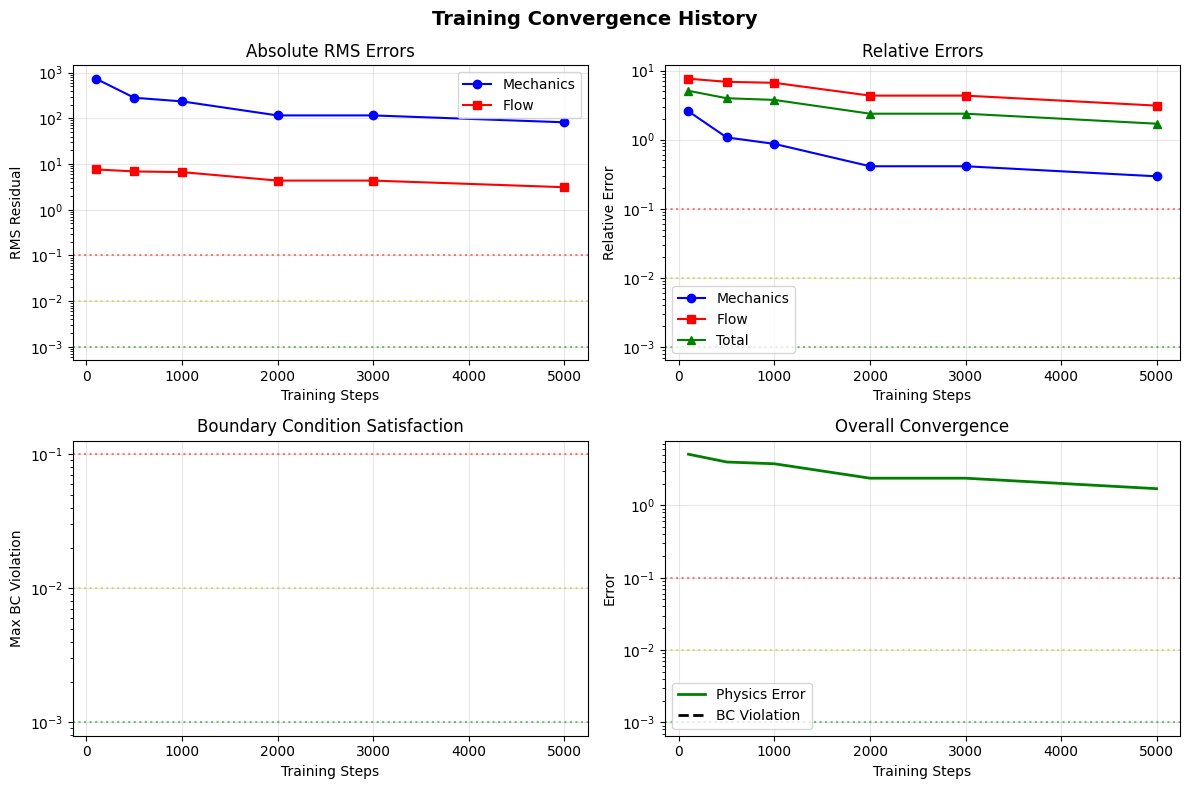



PHYSICS VALIDATION METRICS (using finite_diff)
[INFO] 2025-08-06 22:19:17 - x_batch
[INFO] 2025-08-06 22:19:17 - (2500, 2), float32, ArrayImpl
[INFO] 2025-08-06 22:19:17 - x_take
[INFO] 2025-08-06 22:19:17 - (7744, 2), float32, ArrayImpl
Computing derivatives using finite differences...

┌─────────────────┬──────────────┬──────────────┬──────────────┐
│ Equation        │ RMS Absolute │ RMS Relative │ L-inf Norm   │
├─────────────────┼──────────────┼──────────────┼──────────────┤
│ Mechanics (x)   │ 9.22e+01 │ 3.31e-01 │ 4.35e+02 │
│ Mechanics (y)   │ 7.03e+01 │ 2.53e-01 │ 2.47e+02 │
│ Mechanics (avg) │ 8.20e+01 │ 2.95e-01 │ 4.35e+02 │
│ Flow            │ 3.35e+00 │ 3.35e+00 │ 9.55e+00 │
 └─────────────────┴──────────────┴──────────────┴──────────────┘

Characteristic Scales:
  Domain size (L): 1.00
  Pressure scale: 1.00
  Displacement scale: 5.56e-02
  Elastic force scale: 2.78e+02
  Pressure gradient scale: 1.00e+00

Overall physics satisfaction: NEEDS IMPROVEMENT (avg relative err

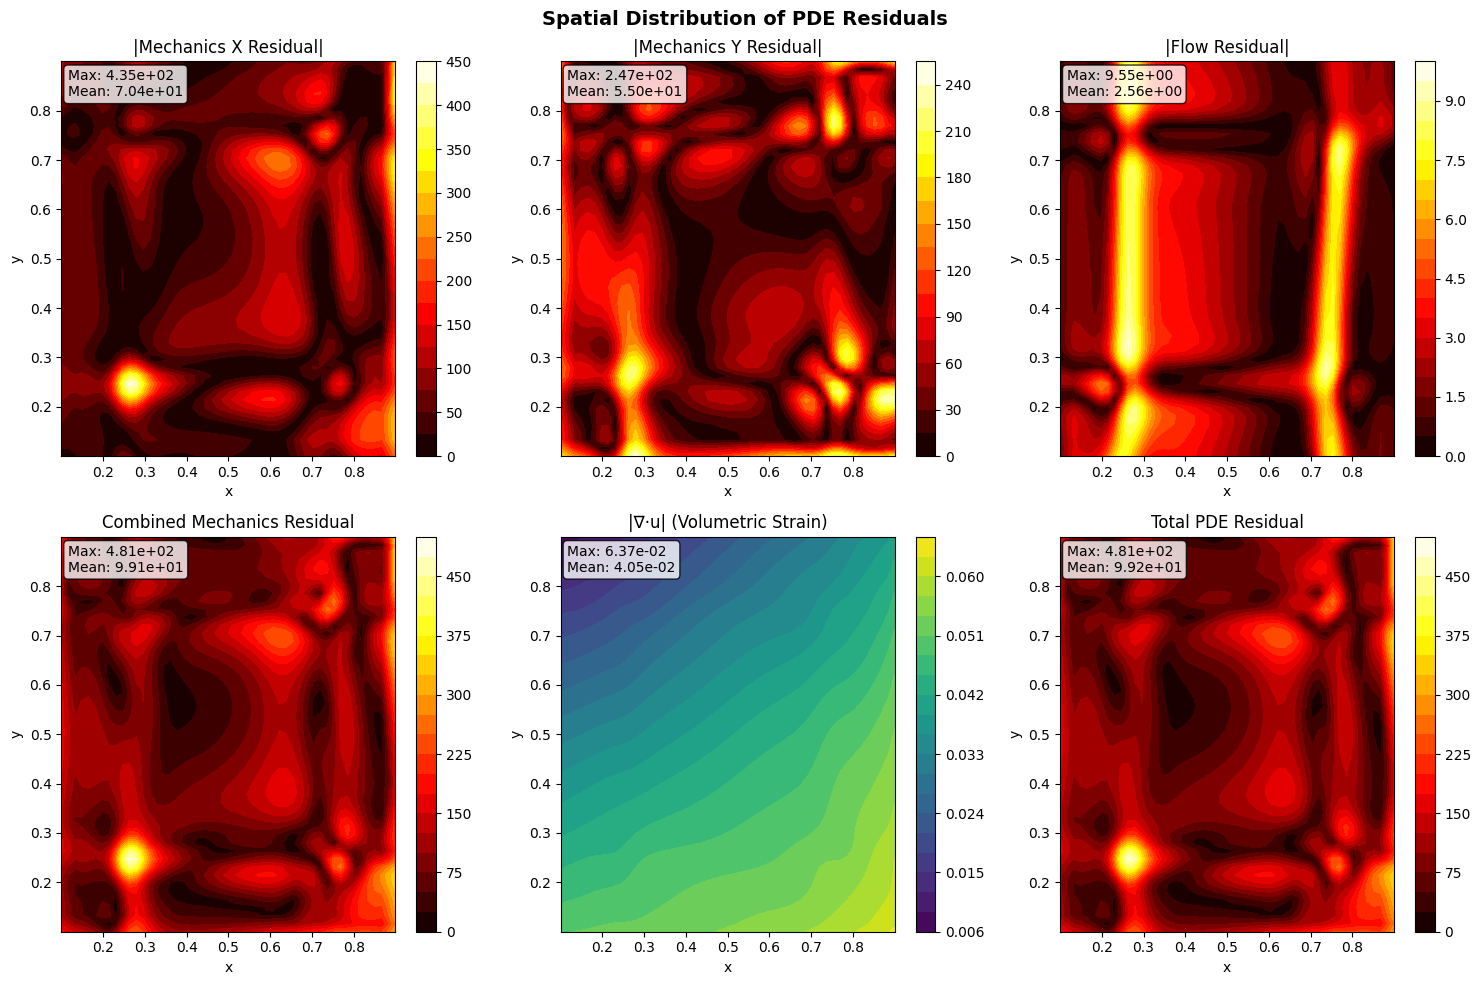


Spatial Residual Analysis:
Maximum total residual location: (x=0.263, y=0.247)
Maximum total residual value: 4.81e+02

Average residual near boundaries: 1.02e+02
Average residual in interior: 9.68e+01
 Errors are relatively uniform across the domain

Boundary Condition Verification
[INFO] 2025-08-06 22:19:19 - x_batch
[INFO] 2025-08-06 22:19:19 - (100, 2), float32, ArrayImpl
[INFO] 2025-08-06 22:19:19 - x_take
[INFO] 2025-08-06 22:19:19 - (160, 2), float32, ArrayImpl
[INFO] 2025-08-06 22:19:20 - x_batch
[INFO] 2025-08-06 22:19:20 - (100, 2), float32, ArrayImpl
[INFO] 2025-08-06 22:19:20 - x_take
[INFO] 2025-08-06 22:19:20 - (160, 2), float32, ArrayImpl
[INFO] 2025-08-06 22:19:20 - x_batch
[INFO] 2025-08-06 22:19:20 - (100, 2), float32, ArrayImpl
[INFO] 2025-08-06 22:19:20 - x_take
[INFO] 2025-08-06 22:19:20 - (160, 2), float32, ArrayImpl
Left boundary (x=0):
  ux = 0: max violation = 0.000000e+00
  uy = 0: max violation = 0.000000e+00
  p = 1:  max violation = 0.000000e+00

Right boun

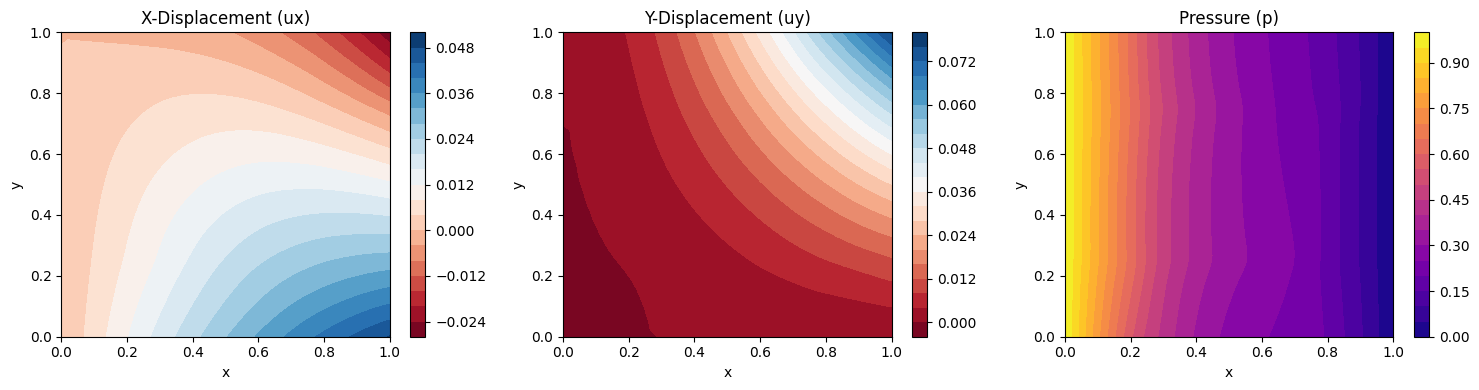


Field Statistics:
ux: min=-0.0267, max=0.0482
uy: min=-0.0003, max=0.0767
p:  min=0.0000, max=1.0000

Physical Behavior Check:
Pressure gradient (left to right): 1.000 -> 0.000
Max displacement at x=1: ux=0.0482
[INFO] 2025-08-06 22:19:22 - x_batch
[INFO] 2025-08-06 22:19:22 - (3, 2), float32, ArrayImpl
[INFO] 2025-08-06 22:19:22 - x_take
[INFO] 2025-08-06 22:19:22 - (3, 2), float32, ArrayImpl

Test Points:
  (0.0, 0.5): ux=0.0000, uy=-0.0000, p=1.0000
  (1.0, 0.5): ux=0.0126, uy=0.0279, p=0.0000
  (0.5, 0.0): ux=0.0277, uy=0.0000, p=0.2863


In [9]:
# Train
trainer = FixedTrainer()

# Train and track convergence history
history = trainer.track_convergence_history(
    checkpoint_steps=[100, 500, 1000, 2000, 3000, 5000],
    save_checkpoints=True
)

# Compute enhanced metrics with relative errors
metrics = trainer.compute_physics_metrics(n_points=50, method='finite_diff')

# Visualize spatial distribution of errors
trainer.plot_residual_spatial_distribution()

# Verify BCs are satisfied
trainer.verify_bcs()

# Visualize domain decomposition first (before training)
trainer.visualize_domain_decomposition()

# Plot the results
trainer.plot_solution()

# Test specific points
x_points = jnp.array([[0.0, 0.5], [1.0, 0.5], [0.5, 0.0]])
predictions = trainer.predict(x_points)
print(f"\nTest Points:")
print(f"  (0.0, 0.5): ux={predictions[0,0]:.4f}, uy={predictions[0,1]:.4f}, p={predictions[0,2]:.4f}")
print(f"  (1.0, 0.5): ux={predictions[1,0]:.4f}, uy={predictions[1,1]:.4f}, p={predictions[1,2]:.4f}")
print(f"  (0.5, 0.0): ux={predictions[2,0]:.4f}, uy={predictions[2,1]:.4f}, p={predictions[2,2]:.4f}")